In [1]:
import shutil, os, sys, time    
import sympy as sp
sys.path.append('nrpy')
sys.path.append(os.path.join('nrpy','CurviBoundaryConditions'))

# Import needed NRPy+ modules:
from outputC import outputC,lhrh,outCfunction,outC_function_dict,add_to_Cfunction_dict # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Module for generating finite differences
import NRPy_param_funcs as par   # NRPy+: Module for handling of parameters
import grid as gri               # NRPy+: Grid and gridfunction creation
import reference_metric as rfm   # NRPy+: Module for handling reference (flat) metric and related expressions
import cmdline_helper as cmd     # NRPy+: Multiplatform command-line interface for compilation and execution of C code
import indexedexp as ixp         # NRPy+: Module for creation of tensorial expressions based on SymPy

import ADM_quantities as ADM


# Create a directory for generated C codes
Ccodesdir = os.path.join("ADM_Ccodes/")

shutil.rmtree(Ccodesdir, ignore_errors=True)
cmd.mkdir(Ccodesdir)

# Create a direcotry for the executable file and its output
outdir = os.path.join(Ccodesdir,"output/")
cmd.mkdir(outdir)

# Set the dimension. NRPy+ assumes default dimension 3. 
par.set_parval_from_str("grid::DIM",3)
DIM = par.parval_from_str("grid::DIM")


# Disable Single Instruction Multiple Data (SIMD)
enable_SIMD = False

# Choose the cordinate system and default values for the parameters of the chosen coordinates.
# CoordSystem     = "Spherical"
CoordSystem = "SinhSpherical"
sinh_width      = 0.1

# Spatial domain size
domain_size     = 1000

RK_method = "RK4"
FD_order  = 4           # Finnite difference order is chosen.
REAL      = "double"    # Floating point accuracy.
default_CFL_FACTOR= 0.5 # Default CFL factor is chosen.

In [2]:
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
RK_order  = Butcher_dict[RK_method][1]
cmd.mkdir(os.path.join(Ccodesdir,"MoLtimestepping/"))
MoL.MoL_C_Code_Generation(RK_method,
    RHS_string      = """
rhs_eval(xx, &params, auxevol_gfs, RK_INPUT_GFS, RK_OUTPUT_GFS);""",
    post_RHS_string = """
apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS, evol_gf_parity, RK_OUTPUT_GFS);""",
    outdir = os.path.join(Ccodesdir,"MoLtimestepping/"))

In [3]:
# Set the Coordinate system.
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
rfm.reference_metric() # Reference metric and related Rescaling quantities are generated by this call.

# Set the finnite differencing order and enable functions for FD. 
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)
enable_FD_functions = True
par.set_parval_from_str("finite_difference::enable_FD_functions", enable_FD_functions)

# For enabled SIMD, file, code containing SIMD definitions is copied to Ccodesdir\SIMD file. 
# For disabed SIMD information for this choice is saved instead.
cmd.mkdir(os.path.join(Ccodesdir,"SIMD"))
if enable_SIMD == True:
    shutil.copy(os.path.join("SIMD","SIMD_intrinsics.h"),os.path.join(Ccodesdir,"SIMD/"))
else:
    with open(os.path.join(Ccodesdir,"SIMD","SIMD_intrinsics.h"), "w") as file:
        file.write("#define SIMD_IS_DISABLED\n")

# Set the symmetry of the problem. For spherically symmetric problem this means we need to set the symmetry axes as
# 1 and 2, which corresponds to \theta and \phi respectively.
par.set_parval_from_str("indexedexp::symmetry_axes","12")

## ID

In [4]:
# Step 1: Give ID in Spherical coordinates.
rthph = ixp.declarerank1("rthph") # Array representing r, \theta and \phi is created.

# The initial data are setup
M  = sp.symbols('M')
psi0 = sp.sqrt(1+ M/rthph[0])

gammaSphDD = ixp.zerorank2()
gammaSphDD[0][0] = psi0**4
gammaSphDD[1][1] = psi0**4 * rthph[0]**2
gammaSphDD[2][2] = psi0**4 * rthph[0]**2*sp.sin(rthph[1])**2

KSphDD = ixp.zerorank2()

KSphDD[0][0] = -M / rthph[0]**2
KSphDD[1][1] = M
KSphDD[2][2] = M * sp.sin(rthph[1])**2

alphaSph = rthph[0] / (rthph[0] + M)
betaSphU = ixp.zerorank1()
# betaU_inSph[0] = M*rthph[0] / (rthph[0] + M)**2

In [5]:
# Step 2: Perform the substitution r, th, ph -> xx0, xx1, xx2.

# Reference metric must be called before setting up the ID.
if rfm.have_already_called_reference_metric_function == False:
    print("Error. Reference metric must be created before setting up the initial data.")
    sys.exit(1)


# Function for substitution is defined.
def sympify_integers__replace_rthph(obj, rthph, rthph_of_xx):
    if isinstance(obj, int):
        return sp.sympify(obj)
    return obj.subs(rthph[0], rthph_of_xx[0]).\
        subs(rthph[1], rthph_of_xx[1]).\
        subs(rthph[2], rthph_of_xx[2])

r_th_ph_of_xx = rfm.xxSph # rfm.xxSph contains spherical coordinates r, th, ph written in terms of xx0, xx1, xx2.

# Substitution is performed.
alphaSph = sympify_integers__replace_rthph(alphaSph, rthph, r_th_ph_of_xx)
for i in range(DIM):
    betaSphU[i] = sympify_integers__replace_rthph(betaSphU[i], rthph, r_th_ph_of_xx)
    # BSphU[i]    = sympify_integers__replace_rthph(BSphU[i],    rthph, r_th_ph_of_xx)
    for j in range(DIM):
        gammaSphDD[i][j] = sympify_integers__replace_rthph(gammaSphDD[i][j], rthph, r_th_ph_of_xx)
        KSphDD[i][j]     = sympify_integers__replace_rthph(KSphDD[i][j],     rthph, r_th_ph_of_xx)

# Step 3: Jacobian transformation needs to be perfomed on the non-scalar quantities.
alpha = alphaSph

# The Jacobian is found by taking the derivative of r, th, ph wrt. to xx0, xx1, xx2.
Jac_dUSph_dDrfmUD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        Jac_dUSph_dDrfmUD[i][j] = sp.diff(r_th_ph_of_xx[i],rfm.xx[j])

# Inverse Jacobian is found using ixp function for matrix inversion.
Jac_dUrfm_dDSphUD, dummyDET = ixp.generic_matrix_inverter3x3(Jac_dUSph_dDrfmUD)

# The unrescaled ADM tensors are assigned.
betaU   = ixp.zerorank1()
gammaDD = ixp.zerorank2()
KDD     = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        betaU[i] += Jac_dUrfm_dDSphUD[i][j] * betaSphU[j]
        for k in range(DIM):
            for l in range(DIM):
                gammaDD[i][j] += Jac_dUSph_dDrfmUD[k][i]*Jac_dUSph_dDrfmUD[l][j] * gammaSphDD[k][l]
                KDD[i][j]     += Jac_dUSph_dDrfmUD[k][i]*Jac_dUSph_dDrfmUD[l][j] *     KSphDD[k][l]
# After this step we are left with ADM quantities with initial data functions in SinhSpherical coordinates.

In [6]:
# Step: Define rescaled quantities in terms of unrescaled quantities.
hDD = ixp.zerorank2()

gammaUU, gammaDET = ixp.symm_matrix_inverter3x3(gammaDD) # _gammaUU unused.

for i in range(DIM):
    for j in range(DIM):
        hDD[i][j] = (gammaDD[i][j] - rfm.ghatDD[i][j]) / rfm.ReDD[i][j]
        
Ktr = sp.sympify(0)
for i in range(DIM):
    for j in range(DIM):
        Ktr += gammaUU[i][j]*KDD[i][j]

aDD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        aDD[i][j]  = (KDD[i][j] - Ktr*gammaDD[i][j]/3)/ rfm.ReDD[i][j]

vetU = ixp.zerorank1()
for i in range(DIM):
    vetU[i] = betaU[i]/rfm.ReU[i]

Code for assignment is generated. 

In [7]:
# Step 5: Generate code for assignment.
includes = []

rhss = [alpha, Ktr]
lhss = ["in_gfs[IDX4S(ALPHAGF,i0,i1,i2)]", "in_gfs[IDX4S(KTRGF,i0,i1,i2)]"]
for i in range(3):
    rhss.append(vetU[i])
    lhss.append("in_gfs[IDX4S(VETU"+str(i)+"GF,i0,i1,i2)]")
    for j in range(i,3):
        rhss.append(hDD[i][j])
        lhss.append("in_gfs[IDX4S(HDD" + str(i) + str(j) + "GF,i0,i1,i2)]")
        rhss.append(aDD[i][j])
        lhss.append("in_gfs[IDX4S(ADD" + str(i) + str(j) + "GF,i0,i1,i2)]")

# Sort the lhss list alphabetically, and rhss to match:
lhss,rhss = [list(x) for x in zip(*sorted(zip(lhss, rhss), key=lambda pair: pair[0]))]

body = outputC(rhss, lhss, filename="returnstring",
               params="preindent=1,CSE_enable=True,outCverbose=False",  # outCverbose=False to prevent
                                                                        # enormous output files.
               prestring="", poststring="")

desc = "Set up the initial data at all points on the numerical grid."
add_to_Cfunction_dict(
    includes=includes,
    desc    =desc,
    name    ="initial_data",
    params  ="const paramstruct *restrict params,REAL *restrict xx[3], REAL *restrict in_gfs",
    body    =body,
    loopopts="AllPoints,Read_xxs") # For analytic data all points can be looped, Read xxs reads gridpoint 

with open(os.path.join(Ccodesdir, "initial_data.h"), "w") as file:
    file.write(outC_function_dict['initial_data'])

## Generate rfm files and timestep

In [8]:
# Output the find_timestep() function to a C file.
rfm.out_timestep_func_to_file(os.path.join(Ccodesdir,"find_timestep.h"))

 # Pokud to tady není, tak se mi nevygenerují rfm files, i když to volám v předchozím kroku
cmd.mkdir(os.path.join(Ccodesdir,"rfm_files/"))
par.set_parval_from_str("reference_metric::enable_rfm_precompute","False")
par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir",os.path.join(Ccodesdir,"rfm_files/"))

rfm.reference_metric()

# setup sGB ADM quantitites and calculate RHS for the equations

In [9]:
ADM.set_KO(False)
ADM.setup_ADM_quantities()
ADM.setup_ADM_equations()


Register gridfunctions and parameters

In [10]:
alpha = gri.register_gridfunctions("EVOL", "alpha")
hDD = ixp.register_gridfunctions_for_single_rank2("EVOL", "hDD", "sym01")
aDD = ixp.register_gridfunctions_for_single_rank2("EVOL", "aDD", "sym01")
Ktr = gri.register_gridfunctions("EVOL", "Ktr")
vetU = ixp.register_gridfunctions_for_single_rank1("EVOL","vetU")


thismodule = "ADM"
M = par.Cparameters("REAL", names = ["M"], module = thismodule,default_vals = 1.0)


Hconstr = gri.register_gridfunctions("AUX","Hconstr")

Generate function for MOL algorithm. 

In [11]:
lhs_names = ['alpha', "Ktr"]
rhs_expressions = [ADM.alpha_rhs, ADM.Ktr_rhs]
for i in range(DIM):
    lhs_names.append('vetU'+str(i))
    rhs_expressions.append(ADM.vetU_rhs[i])
    for j in range(i, DIM):
        lhs_names.append('hDD'+str(i)+str(j))
        rhs_expressions.append(ADM.hDD_rhs[i][j])
        lhs_names.append('aDD'+str(i)+str(j))
        rhs_expressions.append(ADM.aDD_rhs[i][j])

# Order the expressions alphabetically
sorted_dict = dict(sorted({key:value for key,value in zip(lhs_names,rhs_expressions)}.items()))
lhs_names = list(sorted_dict.keys())
rhs_expressions = list(sorted_dict.values())

lhrh_list = []
for var in range(len(lhs_names)):
    lhrh_list.append(lhrh(lhs = gri.gfaccess("rhs_gfs", lhs_names[var]), rhs = rhs_expressions[var]))

outCparams = "outCverbose=False"
loopopts = "InteriorPoints,Read_xxs"
if enable_SIMD:
    loopopts += ",enable_SIMD"
    outCparams += ",enable_SIMD=True"

includes =  ['math.h']
if enable_FD_functions:
    includes += ["finite_difference_functions.h"]

# loopopts += "enable_rfm_precompute"

desc = "Evaluate the sGB ADM RHSs"
name = "rhs_eval"
outfile = os.path.join(Ccodesdir,name+".h")
params = """REAL *restrict xx[3], const paramstruct *restrict params,
            const REAL *restrict auxevol_gfs, const REAL *restrict in_gfs, REAL *restrict rhs_gfs"""
body = fin.FD_outputC("returnstring", lhrh_list, params = outCparams, upwindcontrolvec=betaU)

outCfunction(outfile = outfile, includes = includes, desc = desc, name = name,
                params = params, body = body, loopopts = loopopts)

Output C function rhs_eval() to file ADM_Ccodes/rhs_eval.h


## Implement Hamiltonian

In [12]:
H = ADM.Hconstr

includes = ['math.h']
if enable_FD_functions:
    includes += ["finite_difference_functions.h"]
desc="Evaluate the Hamiltonian constraint"
name="H_eval"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), includes=includes, desc=desc, name=name,
    params   = """REAL *restrict xx[3],const paramstruct *restrict params,
                      REAL *restrict in_gfs, REAL *restrict aux_gfs""",
    body     = fin.FD_outputC("returnstring", lhrh(lhs = gri.gfaccess("aux_gfs","Hconstr"), rhs = H), params = "outCverbose=False"),
    loopopts = "InteriorPoints,Read_xxs")

Output C function H_eval() to file ADM_Ccodes/H_eval.h


In [13]:
if enable_FD_functions:
    fin.output_finite_difference_functions_h(path=Ccodesdir)

## Set C parameters

In [14]:
KO_enabled = False

eps_0 = 0.99
r_ko = 2
w_ko = 0.17

parameter_string = """
// (Set free-parameter values.

// Set free-parameter values for BSSN evolution:
params.M  = 1;\n"""

if KO_enabled:
    parameter_string += f"params.eps_0 = {eps_0};\n"
    parameter_string += f"params.r_ko = {r_ko};\n"
    parameter_string += f"params.w_ko = {w_ko};\n"

with open(os.path.join(Ccodesdir,"free_parameters.h"),"w") as file:
    file.write(parameter_string)
# 0.4878524367
rfm.out_default_free_parameters_for_rfm(os.path.join(Ccodesdir,"free_parameters.h"),
                                        domain_size,sinh_width)
rfm.set_Nxx_dxx_invdx_params__and__xx_h(Ccodesdir)
rfm.xx_to_Cart_h("xx_to_Cart","./set_Cparameters.h",os.path.join(Ccodesdir,"xx_to_Cart.h"))
par.generate_Cparameters_Ccodes(os.path.join(Ccodesdir))

In [15]:
with open(os.path.join(Ccodesdir,"sGB_ADM_REAL__NGHOSTS__CFL_FACTOR.h"), "w") as file:
    file.write("""
#define NGHOSTS """+str(int(FD_order/2)+1)+"""
#define REAL """+REAL+"""
REAL CFL_FACTOR = """+str(default_CFL_FACTOR)+";")

# Generate boundary conditions

In [16]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions(os.path.join(Ccodesdir,"boundary_conditions/"),Cparamspath=os.path.join("../"), path_prefix='nrpy/')

Wrote to file "ADM_Ccodes/boundary_conditions/parity_conditions_symbolic_dot_products.h"
Evolved parity: ( Ktr:0, aDD00:4, aDD01:5, aDD02:6, aDD11:7, aDD12:8,
    aDD22:9, alpha:0, hDD00:4, hDD01:5, hDD02:6, hDD11:7, hDD12:8, hDD22:9,
    vetU0:1, vetU1:2, vetU2:3 )
Auxiliary parity: ( Hconstr:0 )

Wrote to file "ADM_Ccodes/boundary_conditions/EigenCoord_Cart_to_xx.h"


Generate C code for rescaled -> unrescaled calculation

In [17]:
gammaDD = ixp.zerorank2()
ADD = ixp.zerorank2()
# betaU = ixp.zerorank1()

hDD = ixp.declarerank2("hDD", symmetry = "sym01")
aDD = ixp.declarerank2("aDD", symmetry = "sym01")
# vetU = ixp.declarerank1("vetU")

for i in range(DIM):
    betaU[i] += vetU[i]*rfm.ReU[i]
    for j in range(DIM):
        gammaDD[i][j]+= hDD[i][j]*rfm.ReDD[i][j] + rfm.ghatDD[i][j]
        ADD[i][j] += aDD[i][j]*rfm.ReDD[i][j]

gammaDD_sph = ixp.zerorank2()
ADD_sph = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        for k in range(DIM):
            for l in range(DIM):
                gammaDD_sph[i][j] += Jac_dUrfm_dDSphUD[k][i]*Jac_dUrfm_dDSphUD[l][j] * gammaDD[k][l]
                ADD_sph[i][j]     += Jac_dUrfm_dDSphUD[k][i]*Jac_dUrfm_dDSphUD[l][j] *     ADD[k][l]

unrescale_string =[]
for i in range(DIM):
    for j in range(i,DIM):
        unrescale_string.append(lhrh(lhs= gri.gfaccess("rhs_gfs",f"hDD{i}{j}"), rhs = gammaDD_sph[i][j]))
for i in range(DIM):
    for j in range(i,DIM):
        unrescale_string.append(lhrh(lhs= gri.gfaccess("rhs_gfs",f"aDD{i}{j}"), rhs = ADD_sph[i][j]))

# gammaUU_sph,_ = ixp.symm_matrix_inverter3x3(gammaDD_sph)
# # Calculate K to compare to sGB: 
# Ksph = sp.sympify(0)
# for i in range(DIM):
#         Ksph += gammaUU_sph[i][i]*KDD_sph[i][i]
# K_sph = sp.simplify(K_sph)

# # Store into alphaGF, this will be used only to write into diagnostic_output_gfs, where alphaGF is unused. 
# unrescale_string.append(lhrh(lhs = gri.gfaccess("rhs_gfs","alpha"), rhs = K))

In [18]:
includes = None
desc="find unrescaled ADM quantities where necessary"
name="ADM_unrescale"
outCfunction(
    outfile  = os.path.join(Ccodesdir,name+".h"), includes=includes, desc=desc, name=name,
    params   = """REAL *restrict xx[3],const paramstruct *restrict params,
                  const REAL *restrict auxevol_gfs,const REAL *restrict in_gfs,REAL *restrict rhs_gfs""",
    body     = fin.FD_outputC("returnstring", unrescale_string),
    loopopts = "InteriorPoints, Read_xxs")

Output C function ADM_unrescale() to file ADM_Ccodes/ADM_unrescale.h


In [19]:
%%writefile $Ccodesdir/ADM.c

#include "sGB_ADM_REAL__NGHOSTS__CFL_FACTOR.h"

//#include "rfm_files/rfm_struct__declare.h"

#include "declare_Cparameters_struct.h"

#include "SIMD/SIMD_intrinsics.h"
#ifdef SIMD_IS_DISABLED
#define UPWIND_ALG(UpwindVecU) UpwindVecU > 0.0 ? 1.0 : 0.0
#endif

#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"
#include "stdint.h"
#include <string.h>

#ifndef M_PI
#define M_PI 3.141592653589793238462643383279502884L
#endif

#ifndef M_SQRT1_2
#define M_SQRT1_2 0.707106781186547524400844362104849039L
#endif

#define wavespeed 1.0 // CFL wavespeed set to 1.0


#define IDX4S(g,i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
#define IDX4ptS(g,idx) ( (idx) + (Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2) * (g) )
#define IDX3S(i,j,k) ( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) ) ) )
#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)


#include "boundary_conditions/gridfunction_defines.h"
#include "xx_to_Cart.h"
#include "set_Nxx_dxx_invdx_params__and__xx.h"
#include "boundary_conditions/CurviBC_include_Cfunctions.h"

#include "find_timestep.h"
#include "initial_data.h"

int time_step;
#define M_SIZE 5

#include "rhs_eval.h"
# include "ADM_unrescale.h"
#include "H_eval.h"



int main(int argc, const char *argv[]) {

	// for simplicity no command line parameters are checked here
	if(argc == 5) CFL_FACTOR = strtod(argv[4], NULL);
	const int Nxx[3] = {atoi(argv[1]), atoi(argv[2]), atoi(argv[3])};


	paramstruct params;
	#include "set_Cparameters_default.h"
	#include "free_parameters.h"


	REAL *xx[3];
	bc_struct bcstruct;
	{
		int EigenCoord = 1;
		set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);
		#include "set_Cparameters-nopointer.h"
		const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;
		#include "boundary_conditions/driver_bcstruct.h"
		for(int i=0; i<3; i++) free(xx[i]);
	}

	int EigenCoord = 0;
	set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);

	#include "set_Cparameters-nopointer.h"
	const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

	const REAL t_final = 10;
	REAL dt = find_timestep(&params, xx);
	char filename[100];
	sprintf(filename, "t_dt_%d.txt", Nxx[0]);
	FILE *out_tdt = fopen(filename, "w");
	fprintf(out_tdt, "%.15e %.15e\n", t_final, dt);
	fclose(out_tdt);

	int N_final = (int)(t_final / dt + 0.5);
	printf("Number of time steps N_final = %d\n", N_final);


	#include "MoLtimestepping/RK_Allocate_Memory.h"
	REAL *restrict auxevol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_AUXEVOL_GFS * Nxx_plus_2NGHOSTS_tot);

	//#include "rfm_files/rfm_struct__malloc.h"

	{
		#include "set_Cparameters-nopointer.h"
		//#include "rfm_files/rfm_struct__define.h"
	}

	initial_data(&params, xx, y_n_gfs);

	apply_bcs_curvilinear(&params, &bcstruct, NUM_EVOL_GFS, evol_gf_parity, y_n_gfs);

	for(int n=0; n<=N_final; n++) {
        time_step = n;

		#include "MoLtimestepping/RK_MoL.h"

		if(n % 5 == 0 || n==N_final) {

            ADM_unrescale(xx, &params, auxevol_gfs, y_n_gfs, diagnostic_output_gfs);
			H_eval(xx, &params, y_n_gfs, diagnostic_output_gfs);

			char filename[100];
			sprintf(filename, "out%d-%08d.txt", Nxx[0], n);
            if(n == N_final){
			sprintf(filename, "out%d.txt", Nxx[0]);
            }
			FILE *out2D = fopen(filename, "w");

			LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,
	                    NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,
	                    NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {

				const int idx = IDX3S(i0, i1, i2);
				REAL xx0 = xx[0][i0]; REAL xx1 = xx[1][i1]; REAL xx2 = xx[2][i2];
				REAL xCart[3];
				xx_to_Cart(&params, xx, i0, i1, i2, xCart);
				fprintf(out2D, "%e %e %e %e %e %e %e %e\n", xCart[0],xCart[1],xCart[2],
												   log10(fabs(diagnostic_output_gfs[IDX4ptS(HCONSTRGF, idx)])),
                                                   diagnostic_output_gfs[IDX4ptS(ADD00GF, idx)],
                                                   diagnostic_output_gfs[IDX4ptS(ALPHAGF, idx)],
                                                   diagnostic_output_gfs[IDX4ptS(HDD00GF, idx)],
                                                   y_n_gfs[IDX4ptS(KTRGF, idx)]);
			}
			fclose(out2D);
		}

	}
	//#include "rfm_files/rfm_struct__freemem.h"
	#include "boundary_conditions/bcstruct_freemem.h"
	#include "MoLtimestepping/RK_Free_Memory.h"
	free(auxevol_gfs);
	for(int i=0; i<3; i++) free(xx[i]);

	return 0;

}

Writing ADM_Ccodes//ADM.c


In [20]:
import cmdline_helper as cmd
CFL_FACTOR= 1
cmd.C_compile(os.path.join(Ccodesdir,"ADM.c"),
              os.path.join(outdir,"ADM"),compile_mode="optimized")

# Change to output directory
os.chdir(outdir)
# Clean up existing output files
cmd.delete_existing_files("out*.txt")
cmd.delete_existing_files("out*.png")
# Run executable
r_resolutions = [180, 200, 220]
# r_resolutions = [100]
for res in r_resolutions:
    cmd.Execute("ADM", str(res)+" 2 2 "+str(CFL_FACTOR))
# cmd.Execute("sGB_ADM", "96 2 2 "+str(CFL_FACTOR))

# Return to root directory
os.chdir(os.path.join("../../"))

Compiling executable...
(EXEC): Executing `gcc -std=gnu99 -Ofast -fopenmp -march=native -funroll-loops ADM_Ccodes/ADM.c -o ADM_Ccodes/output/ADM.exe -lm`...
(BENCH): Finished executing in 3.2407495975494385 seconds.
Finished compilation.
(EXEC): Executing `cmd /c ADM 180 2 2 1`...
(BENCH): Finished executing in 10.468006372451782 seconds.
(EXEC): Executing `cmd /c ADM 200 2 2 1`...
(BENCH): Finished executing in 11.86916208267212 seconds.
(EXEC): Executing `cmd /c ADM 220 2 2 1`...
(BENCH): Finished executing in 16.294931173324585 seconds.


In [21]:
import simulation_graphs as sg
import os
import sympy as sp
name_dict = {3: r"$\log_{10}|\mathcal{H}|$", 7: r'$K$'}
r_resolutions = [180, 200, 220]
outdir = os.path.join('ADM_Ccodes',"output/")

r = sp.symbols('r')
M = 1
K = M/(M+r)**2
K_func = sp.lambdify(r, K, "numpy")

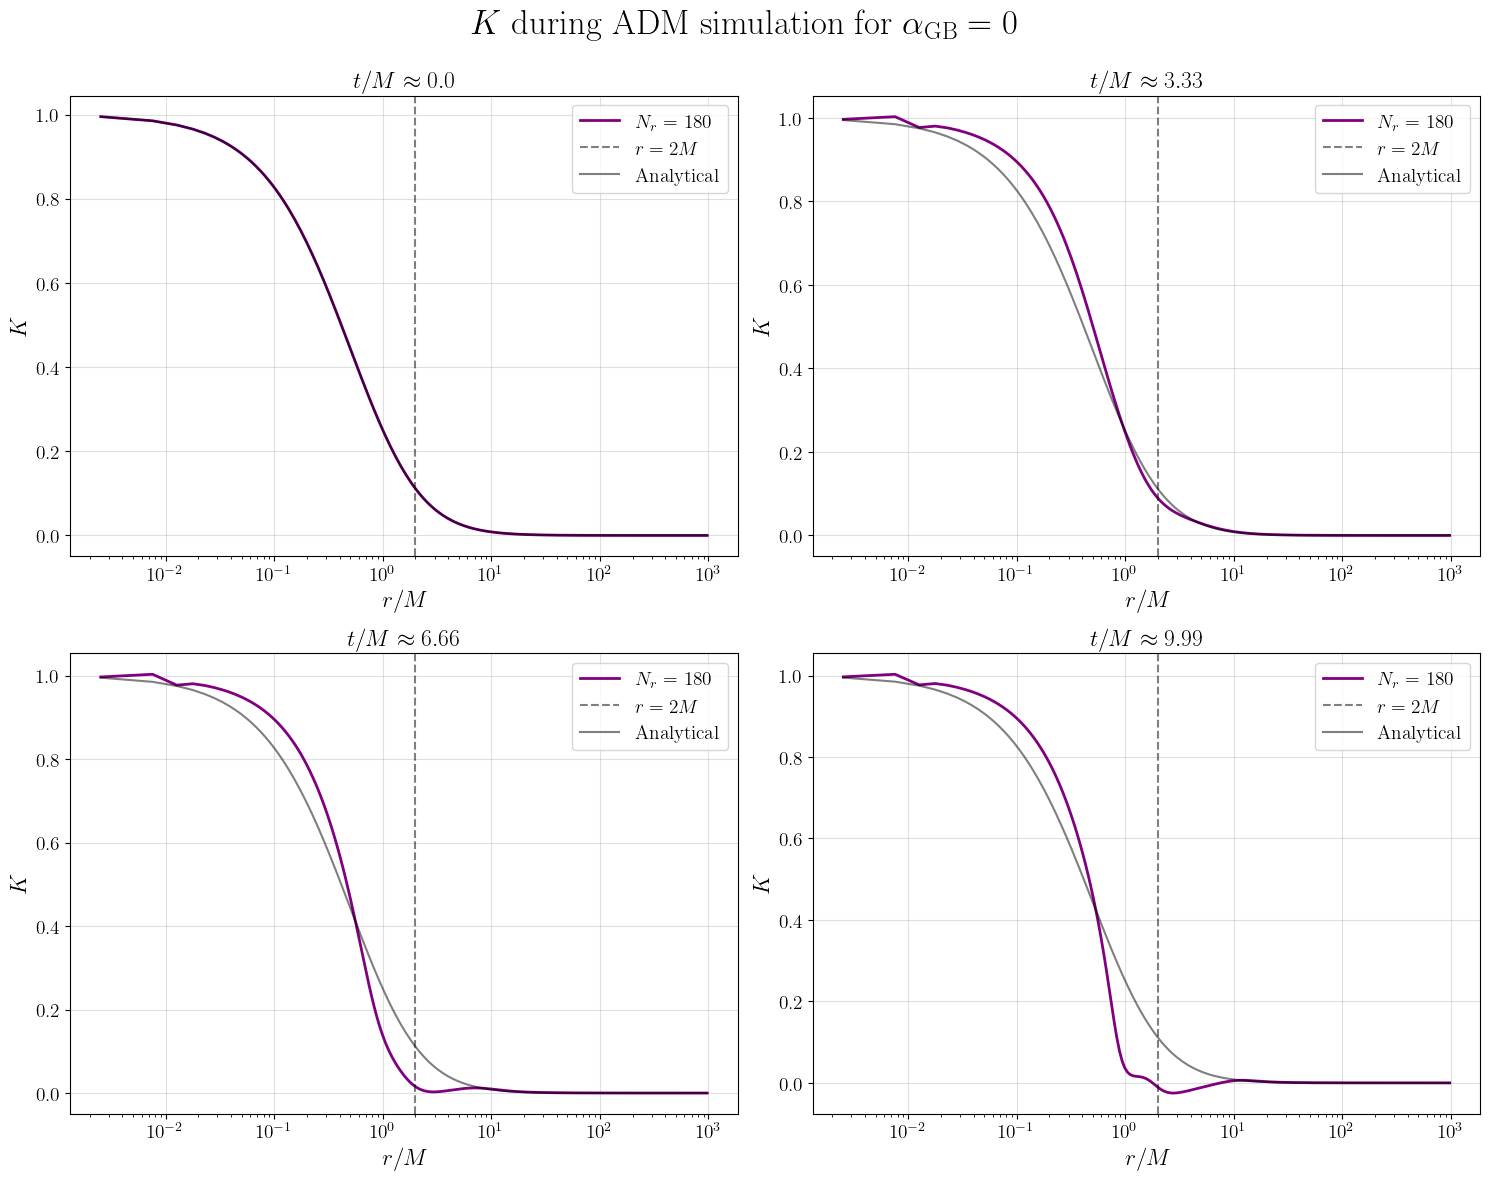

In [22]:
title = r'$K$ during ADM simulation for $\alpha_{\text{GB}}=0$'
sg.plot_evolution_w_anal(7,K_func, outdir, 180, 4, name_dict, title=title)

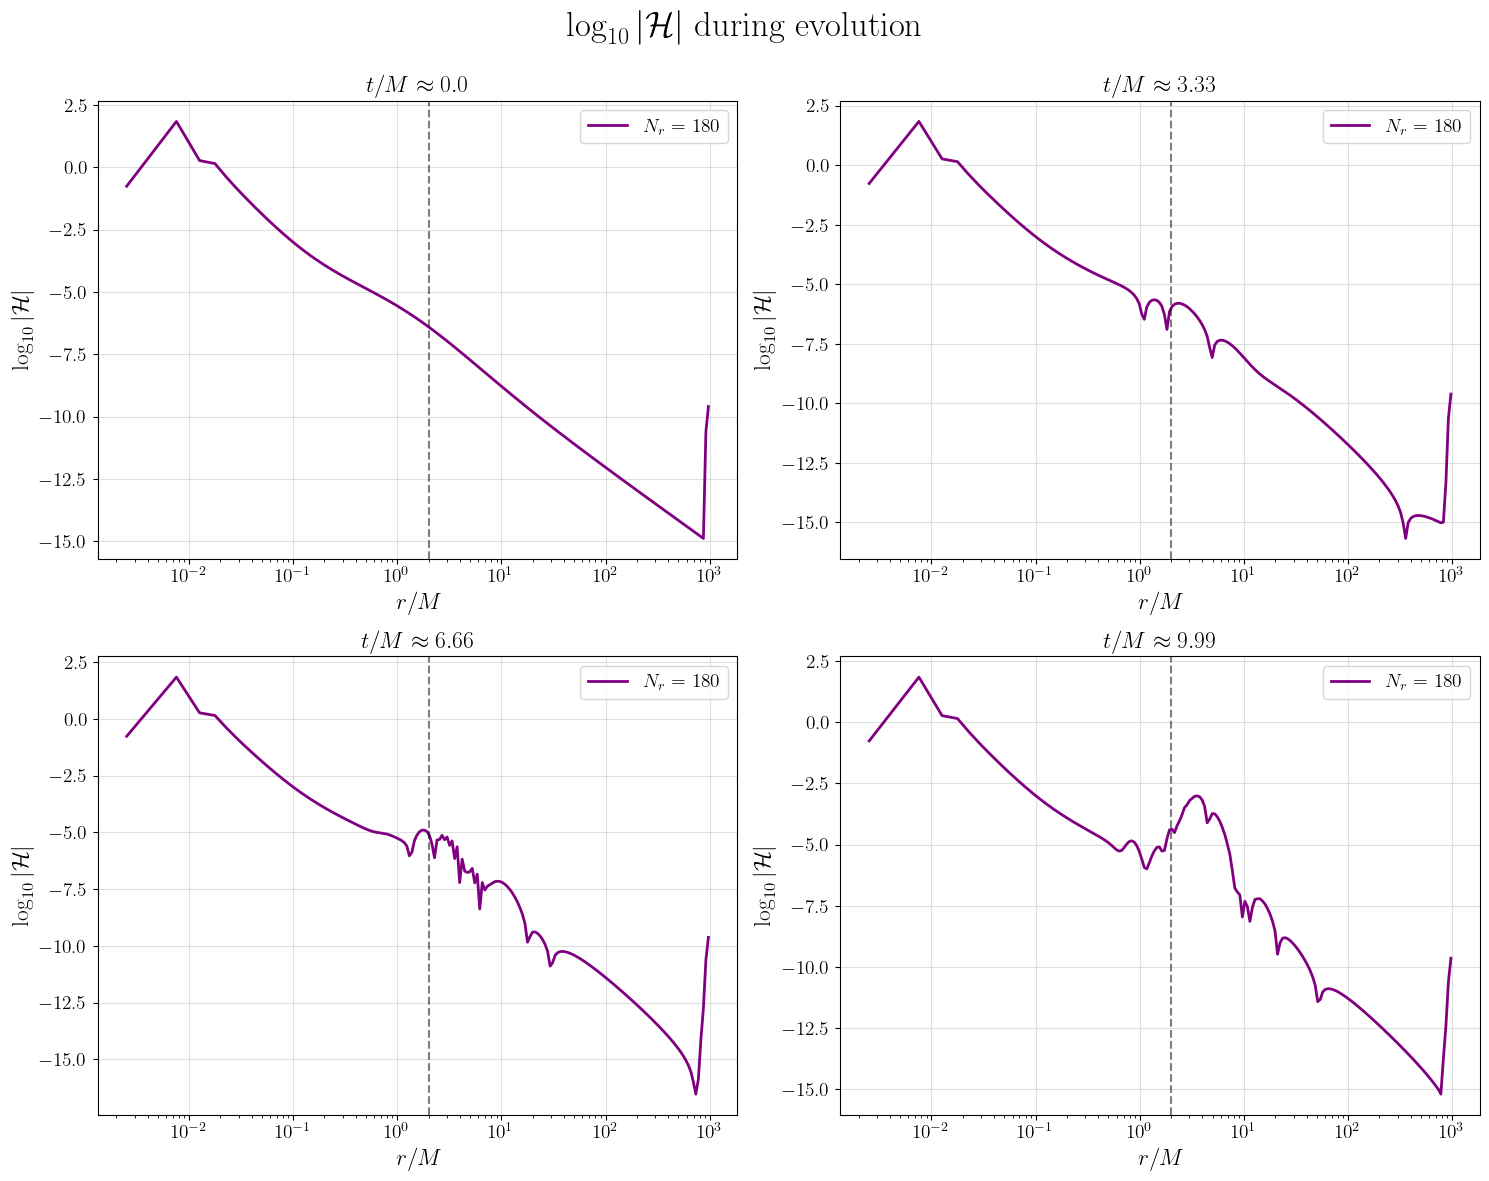

In [23]:
title = r'$\log_{10}|H|$ during sGB ADM simulation for $\alpha_{\text{GB}}=0$'
sg.plot_evolution(3,outdir, 180, 4, name_dict)

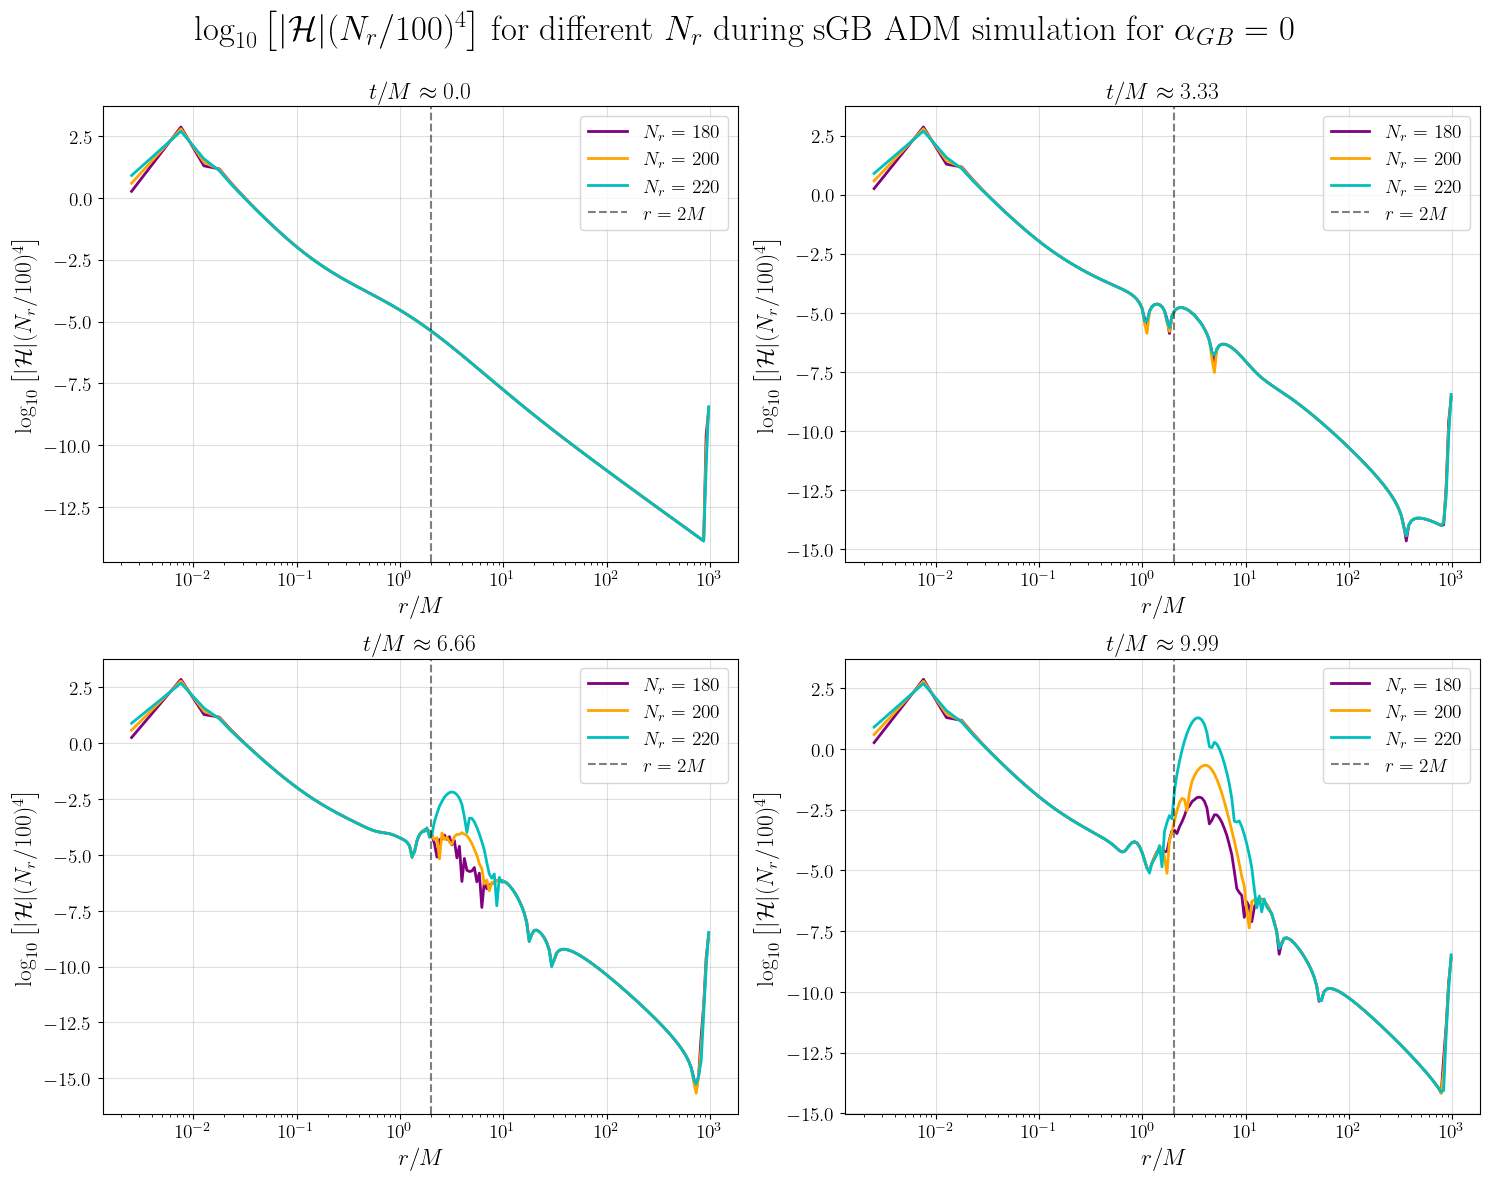

In [25]:
from scipy.interpolate import interp1d
import numpy as np
from matplotlib import pyplot as plt

N_plots = 4

resolutions = r_resolutions
files = [sg.find_filelist(outdir, res) for res in resolutions]
for i in range(len(files)):
    files[i] = sg.select_files(files[i], N_plots)
files = list(map(list, zip(*files)))

num_cols = 2  # Number of columns in the grid
num_rows = (N_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 6))
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

tensor_ind = 3
colors = ['purple', 'orange', 'c']
for i,file_at_step in enumerate(files):
    rs = []	
    hs = []	
    for res, f in zip(resolutions,file_at_step):
        rr, hh = sg.get_data_from_file(3, f)
        hh = hh + np.log10((res/100)**4)
        rs.append(rr)
        hs.append(hh)
    r1, r2, r3 = rs
    H1, H2, H3 = hs
    # Create an interpolation function for H200 on r200 grid
    interp_func1 = interp1d(r2, H2, kind='linear', fill_value="extrapolate")
    interp_func2 = interp1d(r3, H3, kind='linear', fill_value="extrapolate")

    # Interpolate H200 values on the r100 grid
    H2_on_r1 = interp_func1(r1)
    H3_on_r1 = interp_func2(r1)


    axs[i].plot(r1, H1, label=f'$N_r = $ {resolutions[0]}', color=colors[0], linewidth=2)
    axs[i].plot(r1, H2_on_r1, label=f'$N_r = $ {resolutions[1]}', color=colors[1], linewidth=2)
    axs[i].plot(r1, H3_on_r1, label=f'$N_r = $ {resolutions[2]}', color=colors[2], linewidth=2)

    axs[i].set_xscale('log')
    axs[i].axvline(x=2, color='black', linestyle='--', linewidth=1.5, label='$r = 2M$', alpha = 0.5)
    # axs[i].set_ylim(-15, 2.5)
    axs[i].set_xlabel('$r/M$', fontsize=17)
    axs[i].set_ylabel(r'$\log_{10}\big[|\mathcal{H}| (N_{r}/100)^4$\big]', fontsize=17)
    dt = sg.find_dt(outdir, resolutions[0])
    file_index = sg.get_file_index(file_at_step[0])
    axs[i].set_title(f'$t/M \\approx {round(int(file_index) * dt + dt, 2)}$', fontsize=17)

    # Improved legend placement
    axs[i].legend(fontsize = 14)

    # Add a grid for better readability
    axs[i].grid(alpha=0.4)

    axs[i].tick_params(axis='both', which='major', labelsize=14)

fig.suptitle(r'$\log_{10}\big[|\mathcal{H}| (N_{r}/100)^4$\big] for different $N_r$ during sGB ADM simulation for $\alpha_{GB} = 0$', fontsize=25)

plt.tight_layout(rect=[0, 0, 1, 0.98])  


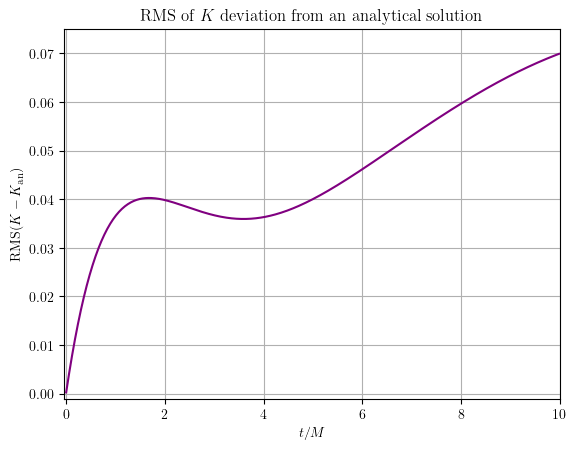

In [27]:
files_for_rms = sg.find_filelist(outdir, 180)
dt = sg.find_dt(outdir,180)
def rms(arr):
    return np.sqrt(np.mean(arr**2))
t = []
rmsK = []
for f in files_for_rms:
    r, K = sg.get_data_from_file(7, f)
    t.append(int(sg.get_file_index(f))*dt)
    rmsK.append(rms(K - K_func(r)))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')  # Optional: to use a serif font
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') 

plt.plot(t, rmsK, color='purple')
plt.xlabel(r'$t/M$')
plt.xlim(-0.05, 10)
plt.ylim(-0.001,0.075)
plt.ylabel(r'RMS$(K-K_\text{an})$')
plt.grid()
plt.title(r'RMS of $K$ deviation from an analytical solution')
plt.show()


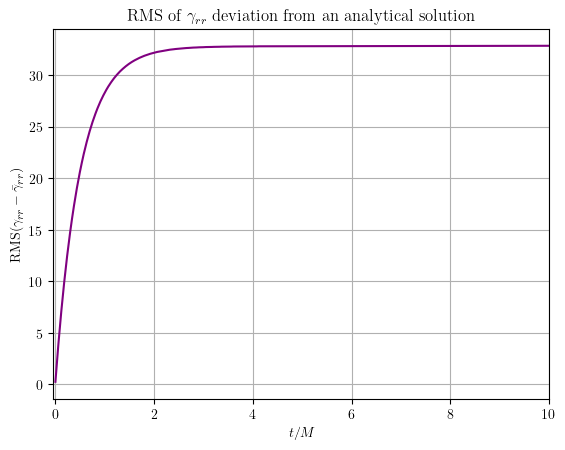

In [28]:
r = sp.symbols('r')
M = 1
grr_s = (1 + M/r)**2
grr_func = sp.lambdify(r, grr_s, "numpy")


files_for_rms = sg.find_filelist(outdir, 180)
dt = sg.find_dt(outdir,180)
def rms(arr):
    return np.sqrt(np.mean(arr**2))
t = []
rmsgrr = []
for f in files_for_rms:
    r, grr = sg.get_data_from_file(6, f)
    t.append(int(sg.get_file_index(f))*dt)
    rmsgrr.append(rms(grr - grr_func(r)))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')  # Optional: to use a serif font
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') 

plt.plot(t, rmsgrr, color='purple')
plt.xlabel(r'$t/M$')
plt.xlim(-0.05, 10)
plt.ylabel(r'RMS$(\gamma_{rr}-\bar{\gamma}_{rr})$')
plt.grid()
plt.title(r'RMS of $\gamma_{rr}$ deviation from an analytical solution')
plt.show()
